  # <center> Taller 2 - Topicos en aprendizaje de Máquinas </center>
## <center>Samuel Suárez 202221595 </center>

## Setup inicial
Instalamos e importamos los paquetes usados en el proyecto y creamos los datos con forma de luna, que buscaremos usar para predicción haciendo uso de un Random Forest.

### Importamos paquetes

In [39]:
# Puede ser necesario instalar scikit-learn y matplotlib en una celda de código separada con los comandos:
# pip install -U scikit-learn
# pip install -U matplotlib
# pip install -U pandas
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd


### Creamos los datos

In [40]:
# Creamos los datos
X, y = make_moons(n_samples= 1000, random_state = 4, noise = 0.2)

## Exploración de datos
Iniciamos viendo la estructura de la base de datos.

### Estructura

In [41]:
# Miramos los datos
print("Algunos de los datos en x se ven así")
print(X[:10, ])
print("")

print("Algunos de los datos en y se ven así")
print(y[:10])
print("")

# Miramos las proporciones de la clase objetivo
print("")
print(f"Las clases para 'y' se dividen en {np.sum(y)*100/len(y)}% de los datos para una clase y {100-np.sum(y)*100/len(y)}% para la otra clase")

Algunos de los datos en x se ven así
[[ 0.70622581 -0.52454151]
 [ 0.10321524  0.10550691]
 [ 0.99140343 -0.6557388 ]
 [ 1.41580476 -0.66163974]
 [ 0.2919172   0.6853116 ]
 [ 1.18869538 -0.06267371]
 [ 1.81075282  0.51196956]
 [ 1.89213882  0.63962874]
 [ 1.21149414 -0.2778553 ]
 [ 0.59887578  1.13861534]]

Algunos de los datos en y se ven así
[1 1 1 1 1 1 1 1 1 0]


Las clases para 'y' se dividen en 50.0% de los datos para una clase y 50.0% para la otra clase


Note que la base de datos contiene dos variables explicativas y una variable explicada con clases balanceadas. A continuación procedemos a graficar la base de datos, usando las dos variables de los datos creados.

### Grafica de los datos

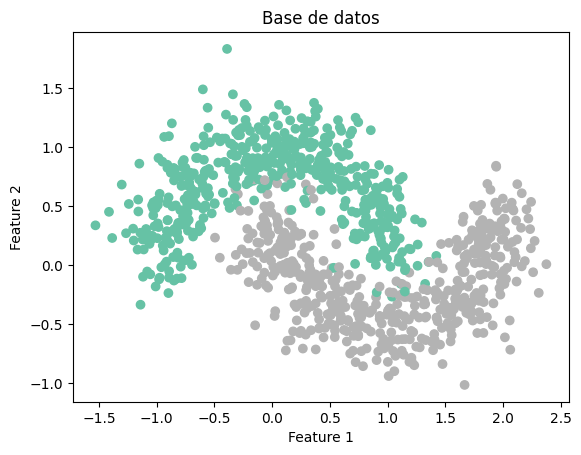

In [42]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set2')
plt.title("Figura 1: Base de datos")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

## Separación de datos
A continuación procedemos a separar los datos en datos de entrenamiento, prueba y validación.

In [43]:
# Separamos los datos con un split de 70% para entrenamiento y 30% para prueba
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=888, test_size=0.3)

## El compromiso entre sesgo y varianza en un arbol de decisión
A continuación, buscaremos iterar por arboles de decisión de distintas profundidades para ver cómo la profundidad puede aumentar la complejidad de nuestro arbol de decisión, mostrando así el compromiso que hay entre sesgo y varianza.

In [69]:
# Crear un loop (for) para validar el resultado en accuracy para distintos k. Guardar los resultados en entrenamiento y prueba
train_scores = []
test_scores = []

profundidad = np.arange(1, 16, 1)

for d in profundidad:
    arbol = DTC(criterion='entropy',
    max_depth = d,
    random_state = 4)
    arbol.fit(X, y)
    arbol.fit(x_train, y_train)
    train_scores.append(1-accuracy_score(y_train, arbol.predict(x_train)))
    test_scores.append(1- accuracy_score(y_test, arbol.predict(x_test)))

# Mostramos los resultados
df = pd.DataFrame({
    'Profundidad': profundidad,
    'Error en entrenamiento': train_scores,
    'Error en prueba': test_scores
})

df

,Profundidad,Error en entrenamiento,Error en prueba
0,1,0.154286,0.196667
1,2,0.084286,0.090000
2,3,0.084286,0.090000
3,4,0.084286,0.090000
4,5,0.021429,0.046667
5,6,0.017143,0.040000
6,7,0.012857,0.040000
7,8,0.012857,0.040000
8,9,0.007143,0.043333
9,10,0.007143,0.040000


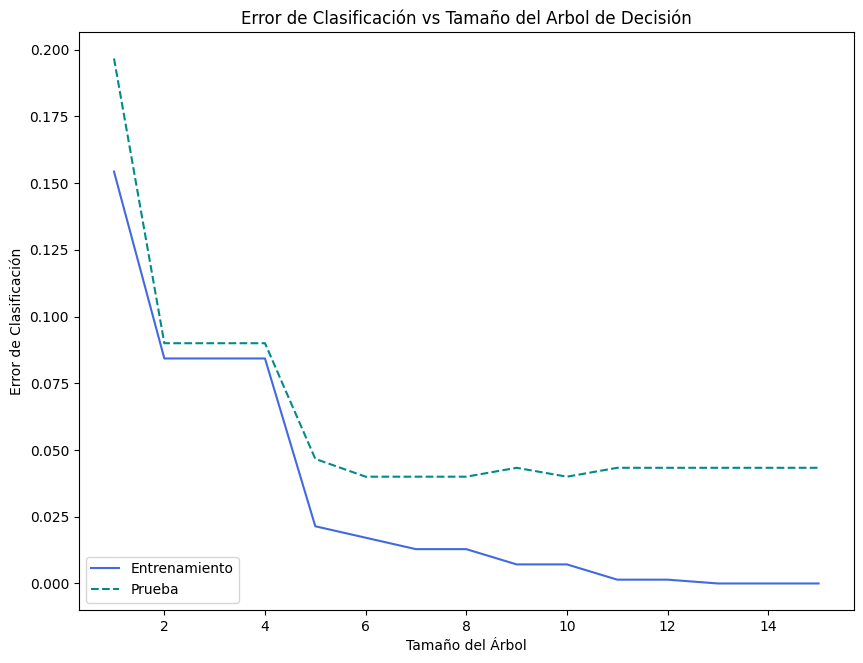

In [72]:
# Gráfique los resultados del loop

plt.figure(figsize=(10,7.5))
plt.plot(df['Profundidad'], df['Error en entrenamiento'], c="royalblue", label="Entrenamiento")
plt.plot(df['Profundidad'], df['Error en prueba'], c="darkcyan", linestyle="--", label="Prueba")
plt.xlabel('Tamaño del Árbol')
plt.ylabel('Error de Clasificación')
plt.title('Figura 2: Error de Clasificación vs Tamaño del Arbol de Decisión')
plt.legend(loc = "lower left")
plt.show()

Vemos en nuestra figura cómo el error de clasificación varía con el tamaño del árbol de decisión, reflejando el compromiso entre sesgo y varianza. Cuando el árbol es muy pequeño, tanto el error de entrenamiento como el de prueba son altos porque el modelo es demasiado simple y presenta alto sesgo (subajuste). A medida que el árbol crece, el error de entrenamiento disminuye casi a cero, pero el error de prueba deja de mejorar y se estabiliza, lo cual sugiere que el modelo esta en un sobreajuste a los datos de entrenamiento, lo cual hará que aumente la varianza. El punto óptimo está en un tamaño intermedio el cual parece ser alrededor de una profundidad de 5.